In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


To mount Google drive, you should run the above lines

In [3]:
pip install mat73

In [4]:
import mat73
import scipy
import scipy.io as sio # cannot use for v7.3 mat file
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# filtering
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, lowcut, fs, order):
  nyq = fs/2
  low = lowcut/nyq
  b, a = butter(order, low, btype='low')
  y = filtfilt(b, a, data) # zero-phase filter # data: [ch x time]
  return y

def butter_highpass_filter(data, highcut, fs, order):
  nyq = fs/2
  high = highcut/nyq
  b, a = butter(order, high, btype='high')
  y = filtfilt(b, a, data) # zero-phase filter
  return y

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
  nyq = fs/2
  low = lowcut/nyq
  high = highcut/nyq
  b, a = butter(order, [low, high], btype='band')
  # demean before filtering
  meandat = np.mean(data, axis=1)
  data = data - meandat[:, np.newaxis]
  y = filtfilt(b, a, data)
  return y

In [9]:
def extractEpoch3D(data, event, srate, baseline, frame, opt_keep_baseline):
  # extract epoch from 2D data into 3D [ch x time x trial]
  # input: event, baseline, frame
  # extract epoch = baseline[0] to frame[2]

  # for memory pre-allocation
  if opt_keep_baseline == True:
    begin_tmp = int(np.floor(baseline[0]/1000*srate))
    end_tmp = int(begin_tmp+np.floor(frame[1]-baseline[0])/1000*srate)
  else:
    begin_tmp = int(np.floor(frame[0]/1000*srate))
    end_tmp = int(begin_tmp+np.floor(frame[1]-frame[0])/1000*srate)
  
  epoch3D = np.zeros((data.shape[0], end_tmp-begin_tmp, len(event)))
  nth_event = 0

  for i in event:
    if opt_keep_baseline == True:
      begin_id = int(i + np.floor(baseline[0]/1000 * srate))
      end_id = int(begin_id + np.floor((frame[1]-baseline[0])/1000*srate))
    else:
      begin_id = int(i + np.floor(frame[0]/1000 * srate))
      end_id = int(begin_id + np.floor((frame[1]-frame[0])/1000*srate))
    
    tmp_data = data[:, begin_id:end_id]

    begin_base = int(np.floor(baseline[0]/1000 * srate))
    end_base = int(begin_base + np.floor(np.diff(baseline)/1000 * srate)-1)
    base = np.mean(tmp_data[:, begin_base:end_base], axis=1)

    rmbase_data = tmp_data - base[:, np.newaxis]
    epoch3D[:, :, nth_event] = rmbase_data
    nth_event = nth_event + 1

  return epoch3D

In [97]:
EEG = mat73.loadmat("s01.mat")

1. For using mat73, data distributor should save mat file using '-v7.3'
2. After loading a file, data filed names are displayed using keys() function, otherwise it prints all names and values at the same time.
3. This dataset consists of structural cell array so their should be a few indicies

In [ ]:
biosemi_montage = mne.channels.make_standard_montage('biosemi32')
fake_info = mne.create_info(ch_names=biosemi_montage.ch_names, sfreq=512.,
                            ch_types='eeg')

fake_evoked = mne.EvokedArray(avg_target, fake_info)
fake_evoked.set_montage(biosemi_montage)

<Evoked | '' (average, N=1), 0 – 1.1973 sec, baseline off, 32 ch, ~202 kB>

Text(0.5, 1.0, 'MNE')

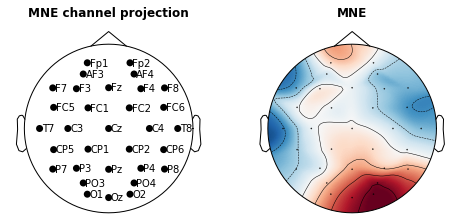

In [ ]:
# create a two-panel figure with some space for the titles at the top
fig, ax = plt.subplots(ncols=2, figsize=(8, 4), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)
# we plot the channel positions with default sphere - the mne way
fake_evoked.plot_sensors(axes=ax[0], show=False, show_names=True)
# add titles
ax[0].set_title('MNE channel projection', fontweight='bold')

mne.viz.plot_topomap(np.mean(fake_evoked.data, axis=1), fake_evoked.info, axes=ax[1], show=False)
ax[1].set_title('MNE', fontweight='bold')

P300 speller letter detect 

In [13]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [99]:
def decimation_by_avg(data, factor):
  """Function for replacing each sequence of previous factor samples with their average"""
  # for example, frame [0, 800]ms -> 17samples (Krusienski et al., 2006)
  # data.shape = [ch, time, trial]
  ratio_dsample = factor
  n_ch, n_frame, n_trial = data.shape

  #print(n_frame)
  decimated_frame = int(np.floor(n_frame/ratio_dsample))
  #print(decimated_frame)

  # memory pre-allocation
  decimated_data = np.zeros((n_ch, decimated_frame, n_trial))
  #print(decimated_data.shape)

  for i in range(n_trial):
    for j in range(decimated_frame):
      cur_data = data[:, :, i]
      decimated_data[:, j, i] = np.mean(cur_data[:, j*ratio_dsample:(j+1)*ratio_dsample], axis=1)

  return decimated_data


down_target = decimation_by_avg(targetEEG, 24)
down_nontarget = decimation_by_avg(nontargetEEG, 24)

ch_target, frame_target, trial_target = down_target.shape
ch_nontarget, frame_nontarget, tiral_nontarget = down_nontarget.shape
feat_target = np.reshape(down_target, (ch_target*frame_target, trial_target))
feat_nontarget = np.reshape(down_nontarget, (ch_nontarget*frame_nontarget, tiral_nontarget))

# feature: [n_samples, n_features]
feat_target = feat_target.transpose() 
feat_nontarget = feat_nontarget.transpose()
# y: 1 for target and -1 for nontarget
y_target = np.ones((feat_target.shape[0],1))
y_nontarget = -np.ones((feat_nontarget.shape[0],1))

feat_train = np.vstack((feat_target, feat_nontarget))
y_train = np.vstack((y_target, y_nontarget))

idx_train = np.arange(feat_train.shape[0])
np.random.shuffle(idx_train)

feat_train = feat_train[idx_train, :]
y_train = y_train[idx_train, :]

# **Train linear classifier and save the model**

In [100]:
def get_stats(dat, x_columns, y):
  x = dat[:, x_columns]
  results = sm.OLS(y, x).fit() # OLS: ordinary least-square
  #print(results.summary())
  return results

# stepwisefit in Matlab for Won2021 - penter: 0.08, <premove: 0.1>, select the best 60 features only
x_column = np.array(range(feat_train.shape[1]))
while True:
  #print(x_column.shape)
  results_stats = get_stats(feat_train, x_column, y_train)
  if np.max(results_stats.pvalues) <= 0.08:
    break
  else:
    backward_elim = np.array(np.where(results_stats.pvalues == np.max(results_stats.pvalues)))
    x_column = np.delete(x_column, backward_elim)

print(x_column.shape)
print(np.max(results_stats.pvalues))

Done
(174,)
0.07934652949623593


In [101]:
argsort_pval = np.argsort(results_stats.pvalues)
x_column = x_column[argsort_pval[range(60)]]

In [102]:
feat_train_select = feat_train[:, x_column]
print(feat_train_select.shape)
# Linear regression
linear_model = LinearRegression()
linear_model.fit(feat_train_select, y_train)

pred_train = np.sign(linear_model.predict(feat_train_select))
np.sum(pred_train==y_train) / len(pred_train)

(1800, 60)


0.8516666666666667

In [104]:
# Save the trained linear model and the selected x_column

mdl = {"linear": linear_model, "feat_column": x_column}
# Save
nsb = 1
fname = f's{nsb}.npy'
np.save(fname, mdl) 

# Load
read_mdl = np.load(fname,allow_pickle='TRUE').item()

In [32]:
EEG['test'][0].keys()

dict_keys(['chanlocs', 'data', 'markers_seq', 'markers_target', 'nbTrials', 'nbTrials_nontarget', 'nbTrials_target', 'online_acc', 'srate', 'text_result', 'text_to_spell'])

# **Letter detection accruacy - using the trained classifier and unknown data**

In [33]:
# Ingredients for P300 speller
spellermatrix = ['A', 'B', 'C', 'D', 'E', 'F', 
                 'G', 'H', 'I', 'J', 'K', 'L',
                 'M', 'N', 'O', 'P', 'Q', 'R',
                 'S', 'T', 'U', 'V', 'W', 'X',
                 'Y', 'Z', '1', '2', '3', '4',
                 '5', '6', '7', '8', '9', '_']
Config_P3speller = {"seq_code": range(1,13), "full_repeat": 15, "spellermatrix": spellermatrix}
Params_P3speller = {"freq": [0.5, 10], "frame": [0, 600], "baseline": [-200, 0], "select_ch": range(1, 33)}

In [162]:
def detect_letter_P3speller(pred_score, word_len, label, letter_ind, markers_seq, params):
  """Function for detecing letter from the predicted results from unknown EEG"""
  user_answer = np.chararray(word_len,1)
  acc_on_repetition = np.zeros(params["full_repeat"])
  correct_on_repetition = np.zeros(params["full_repeat"])
  for n_repeat in range(params["full_repeat"]):
    for n_letter in range(word_len):
      # begin and end trial for a single letter session
      begin_trial = len(params["seq_code"]) * params["full_repeat"] * (n_letter)
      end_trial = begin_trial + (n_repeat+1) * len(params["seq_code"])

      unknown_speller_code = np.zeros(len(params["seq_code"]))
      for j in range(begin_trial, end_trial):
        # predict and add lda score
        unknown_speller_code[int(markers_seq[letter_ind[j]])-1] = unknown_speller_code[int(markers_seq[letter_ind[j]])-1] + pred_score[j]

        row = np.argmax(unknown_speller_code[0:6]) 
        col = np.argmax(unknown_speller_code[6:12])
        user_answer[n_letter] = params['spellermatrix'][row*6+col]
        user_answer_string = user_answer.tobytes().decode('utf-8')
    
    correct_on_repetition[n_repeat] = len([i for i, j in zip(user_answer_string, label) if i == j])
    acc_on_repetition[n_repeat] = correct_on_repetition[n_repeat] / len(label)

  out = {"text_result": user_answer_string, "acc_on_repetition": acc_on_repetition, "correct_on_repetition": correct_on_repetition}
  return out

In [164]:
read_mdl = np.load(fname,allow_pickle='TRUE').item()

for n_test in range(len(EEG['test'])):
  cur_eeg = EEG['test'][n_test]
  data = np.asarray(cur_eeg['data'])
  srate = cur_eeg['srate']
  data = butter_bandpass_filter(data, 0.5, 10, srate, 4)
  markers = cur_eeg['markers_target']
  word_len = int(cur_eeg['nbTrials'] / (len(Config_P3speller['seq_code'])*Config_P3speller['full_repeat']))

  markers_seq = cur_eeg['markers_seq']
  letter_idx = np.where(np.isin(markers_seq, Config_P3speller['seq_code']))[0]

  unknownEEG = extractEpoch3D(data, letter_idx, srate, baseline, frame, False)
  down_unknown = decimation_by_avg(unknownEEG, 24)
  ch_unknown, frame_unknown, trial_unnknown = down_unknown.shape
  feat_unknown = np.reshape(down_unknown, (ch_unknown*frame_unknown, trial_unnknown))
  feat_unknown = feat_unknown.transpose()

  # opt - calculate the all classification results from feat_unknown
  pred_unknown = read_mdl['linear'].predict(feat_unknown[:, read_mdl['feat_column']]) # your answers

  ans_letters = detect_letter_P3speller(pred_unknown, word_len, cur_eeg['text_to_spell'], letter_idx, markers_seq, Config_P3speller);
  cur_text_result = ans_letters['text_result']
  print(f"User answer: {cur_text_result} ({int(ans_letters['correct_on_repetition'][-1])}/{int(word_len)}), accuracy: {ans_letters['acc_on_repetition'][-1]}")


User answer: SUBPECT (6/7), accuracy: 0.8571428571428571
User answer: NEURONS (7/7), accuracy: 1.0
User answer: IMAGINE (7/7), accuracy: 1.0
User answer: QOEFITY (4/7), accuracy: 0.5714285714285714
